In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates
import matplotlib.patches as patches

In [ ]:
# paths
path_in = Path('/Users/mamason6/Documents/workshops/hackweek-2024/data/GM20 SnowPits/parameter_files') # GM2020
path_out = Path('/Users/mamason6/Documents/workshops/hackweek-2024/output')

# reminder: scripts here: 
# /Users/mamason6/Documents/snowex/workshops/hackweek-2024/scripts

In [ ]:
df = pd.DataFrame()

for filename in sorted(path_in.rglob('*stratigraphy*')): # get all LWC parameter files

    # print(filename.name)

    # Define the number of metadata rows in snow pit parameter files
    metadata_rows = 7

    # Read csv file, skipping metadata rows, no data = -9999
    data = pd.read_csv(filename, skiprows=metadata_rows, na_values=-9999)
    
    # add Sample Depth column
    data['center'] = data[['# Top (cm)', 'Bottom (cm)']].mean(axis=1)

    # Read metadata separately, store as dictionary
    metadata = pd.read_csv(filename, nrows=metadata_rows, header=None, index_col=0, squeeze=True).to_dict()
    
    # Add metadata to a new column in the DataFrame
    data['state'] = data.index.map(lambda x: metadata['# PitID'][:2])
    # data['Location'] = data.index.map(lambda x: metadata['# Location'])
    data['site'] = data.index.map(lambda x: metadata['# Site'])
    # data['PitID'] = data.index.map(lambda x: metadata['# PitID'][:6])
    data['uniqueID'] = data.index.map(lambda x: metadata['# PitID'])
    data['date'] = data.index.map(lambda x: metadata['# Date/Local Time'])  
    data['Grain Size (mm)'] = data['Grain Size (mm)'].astype('str')
                                                         
    # convert to pd datetime type - goodness, UGLY
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M')
    data['date'] = data['date'].dt.strftime('%m/%d/%Y')
    data['date'] = pd.to_datetime(data['date'])
    
    # Grow the DataFrame
    df = df.append(data, ignore_index=True)

    # print the datetime as date
    # df['date'].dt.date
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   # Top (cm)       1300 non-null   float64       
 1   Bottom (cm)      1300 non-null   float64       
 2   Grain Size (mm)  1300 non-null   object        
 3   Grain Type       1300 non-null   object        
 4   Hand Hardness    1286 non-null   object        
 5   Manual Wetness   1300 non-null   object        
 6   Comments         596 non-null    object        
 7   center           1300 non-null   float64       
 8   state            1300 non-null   object        
 9   site             1300 non-null   object        
 10  uniqueID         1300 non-null   object        
 11  date             1300 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 122.0+ KB


In [ ]:
df.site.unique()

array(['1N6', '2N4', '3N22', '3N53', '4N2', '5N10', '5N19', '6N18',
       '7N57', '8N25', '8N55', '8N58', '9N59', '1S1', '2S25', '2S36',
       '2S3', '2S48', '3S47', '3S5', '5S24', '5S43', '6C37', '6S19',
       '8S30', '9S51', '2C33', '2S35', '4N27', '5C20', '5C21', '5N41',
       '5S31', '6N31', '6N36', '7C15', '8C25', '8N34', '8N38', '9C17',
       '9C19', '9N29', '1C14', '1C1', '1C7', '1C8', '2C2', '2C3', '2C4',
       '2C6', '2C9', '2N12', '4C30', '6C10', '6C24', '8C22', '8C26',
       '8S28', '9C28', '1S8', '2N48', '2S11', '2S37', '3S14', '3S38',
       '5N50', '5S21', '6C34', '6N46', '8N45', '9N44', '9S39', '9S40',
       'GML', '2S27', '2S46', '3S33', '3S52', '5S29', '5S42', '5S49',
       '6S34', '6S44', '7N40', '8N37', '8N51', '8N52', '8N54', '9N42',
       '9N43', '9N47', '9N56', '1N20', '1S13', '2S10', '2S4', '2S9',
       '6S15', '6S22', '8C11', '8C18', '8C29', '8C35', '8C36', '8N9',
       '8S18', '9C16', '2N13', '2S20', '5N15', '6S32', '6S53', '7S23',
       '7S50', '8

In [ ]:
df['Grain Type'].unique()

# clean up the grain type column
df['Grain Type'] = df['Grain Type'].str.strip()  # Remove leading and trailing spaces
# df['Grain Type'] = df['Grain Type'].str.replace('\n', '') # this should just remove the \n, but make sure it's not making the 'RG\n' to ''

df['Grain Type'].unique()
# liers=df.loc[(df['Grain Type'] == np.nan)]
# liers


#grain size
df['Grain Size (mm)'] = df['Grain Size (mm)'].str.strip()

In [ ]:
df['Hand Hardness'].unique()

array(['4F', 'F', 'P', '1F', '[]', '1F/P', 'K', '4F/P', 'F/4F', '4F/F',
       nan, 'I', '4F/1F', 'P/K'], dtype=object)

In [ ]:
df['Grain Size (mm)'].unique()

array(['< 1 mm', '1-2 mm', '2-4 mm', '4-6 mm', '> 6 mm', '[]'],
      dtype=object)

In [ ]:
# do some rearranging

# rename stuff
df.rename(columns={"# Top (cm)": "top", 
                   "Bottom (cm)": "bottom", 
                   "Grain Size (mm)": "grainSize", 
                   "Grain Type": "grainType", 
                   "Hand Hardness": "hardness", 
                   "Manual Wetness": "wetness"}, inplace=True) # matches Sveta's template (i.e. MagnaProbe counter equivalent)


# reorder and keep desired fields
reorder_cols = ['date', 'state', 'site',
                'top', 'center', 'bottom', 
                'grainType', 'grainSize', 'hardness', 'wetness']
df = df[reorder_cols]

### Change site selection here

In [ ]:
# Limit to a smaller chunk of sites
sites_list = site = ['1S1','1S2', '2S3', '2S4', '3S5', '2S7', '2S6', '1S8']
df = df[df['site'].isin(sites_list)].reset_index(drop=True)

# Sort the DataFrame by the custom order of sites_list
df['site'] = pd.Categorical(df['site'], categories=sites_list, ordered=True)
df = df.sort_values('site').reset_index(drop=True)

df.head()

,date,state,site,top,center,bottom,grainType,grainSize,hardness,wetness
0,2020-01-29,CO,1S1,83.0,82.5,82.0,PP,1-2 mm,F,D
1,2020-01-29,CO,1S1,82.0,73.0,64.0,DF,< 1 mm,4F,D
2,2020-01-29,CO,1S1,64.0,59.5,55.0,DF,< 1 mm,4F,D
3,2020-01-29,CO,1S1,55.0,50.0,45.0,FC,1-2 mm,4F,D
4,2020-01-29,CO,1S1,45.0,39.0,33.0,FC,1-2 mm,4F,D


In [ ]:
# other clean up, prep for plotting

# grainSize, drop the 'mm'

grainSize_key = {
    '< 1 mm': 0.5, 
    '1-2 mm': 1.5, 
    '2-4 mm': 3.0, 
    '4-6 mm': 5.0, 
    '> 6 mm': 6.0, 
}

df['grainSize_no'] = df['grainSize'].map(grainSize_key)

# hardness scale
hardness_key = {
    'F':  1,
    'F/4F': 1.5,
    '4F/F': 1.75,
    '4F': 2,
    '4F/1F': 2.5,
    '1F': 3,
    '1F/P': 3.5,
    'P':  4,
    'P/K': 4.5,
    'K':  5,
    'I':  6
}
df['hardness_no'] = df['hardness'].map(hardness_key)
df.head()

# wetness scale

,date,state,site,top,center,bottom,grainType,grainSize,hardness,wetness,grainSize_no,hardness_no
0,2020-01-29,CO,1S1,83.0,82.5,82.0,PP,1-2 mm,F,D,1.5,1.0
1,2020-01-29,CO,1S1,82.0,73.0,64.0,DF,< 1 mm,4F,D,0.5,2.0
2,2020-01-29,CO,1S1,64.0,59.5,55.0,DF,< 1 mm,4F,D,0.5,2.0
3,2020-01-29,CO,1S1,55.0,50.0,45.0,FC,1-2 mm,4F,D,1.5,2.0
4,2020-01-29,CO,1S1,45.0,39.0,33.0,FC,1-2 mm,4F,D,1.5,2.0


In [ ]:
df['grainType'].unique()

array(['PP', 'DF', 'FC', 'RG', 'PPGP', 'CR', 'SH'], dtype=object)

In [ ]:
# correct grain type labels:
df['grainType'] = df['grainType'].replace('PPGP', 'PPgp')
df['grainType'] = df['grainType'].replace('CR', 'RG') # "wind slab in comments, therefore, 'CR' changed to 'RG'


In [ ]:
df['grainType'].unique()

array(['PP', 'DF', 'FC', 'RG', 'PPgp', 'SH'], dtype=object)

In [ ]:
# save csv
df.to_csv(path_out.joinpath('stratigrapy_subset.csv'), index=False)

In [ ]:
# df[df['site'] == site].date.nunique()
# site_df['date'].nunique()

### Let's plot stratigraphy profiles

/Users/mamason6/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/mamason6/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


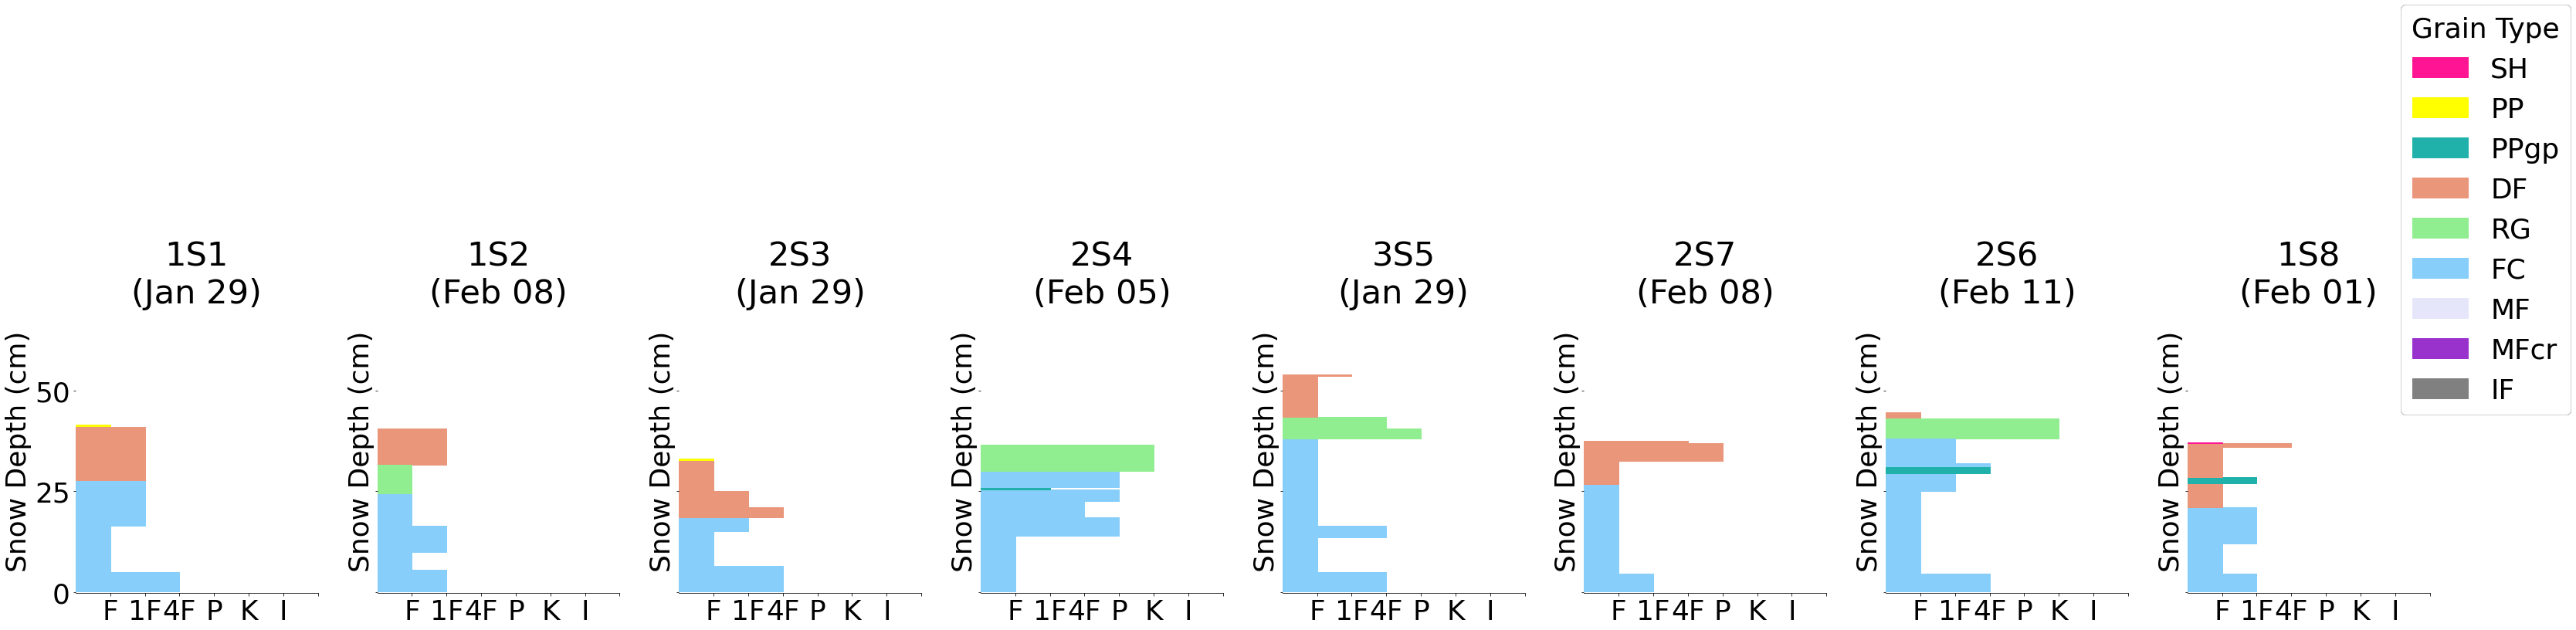

In [26]:
# plotting

# Define colors for each grainType
color_mapping = {
    'SH': 'deeppink',
    'PP': 'yellow',
    'PPgp': 'lightseagreen',
    'DF': 'darksalmon', #'peachpuff',
    'RG': 'lightgreen',
    'FC': 'lightskyblue',
    'MF': 'lavender',
    'MFcr': 'darkorchid',
    'IF': 'grey'
}

state = df['state'][0]
num_sites = df['site'].nunique()

grouped = df.groupby('site')


# Create subplots with 1 row and 'num_sites' columns
fig, axes = plt.subplots(nrows=1, ncols=num_sites, figsize=(45, 8), sharey=True)
plt.rcParams.update({'font.size': 36})

# Iterate through each group and plot on the corresponding subplot
for (site, group), ax in zip(grouped, axes):
    
    # Iterate through rows in the group
    for _, row in group.iterrows():
        color = color_mapping.get(row['grainType'], 'black')  # Default color is grey if grainType is not in mapping
        layer_box = patches.Rectangle((0, row['bottom']), row['hardness_no'], row['top'] - row['bottom'], color=color)
        
        ax.add_patch(layer_box)

        # 'y'
        ax.set_ylim(0, 140) #175 Bogus Upper)
        # ax[i].set_yticks(list(range(0,8)))
        ax.set_yticklabels(['', '', '', '', '', '', '', '',])
        ax.set_yticklabels(['0', '25', '50', '75', '100', '120', '140']) #(['0', '25', '50', '75', '100', '125', '150', '175'])

        # 'x'
        ax.set_xlim(0, 7)
        ax.set_xticks(list(range(1, 8)))
        ax.set_xticklabels(['F', '1F', '4F', 'P', 'K', 'I', ''])
        ax.xaxis.labelpad = 40


        ax.set_ylabel("Snow Depth (cm)")
    
    # Iterate through rows in the group
    for _, row in group.iterrows():
        
        date = row['date']
        color = color_mapping.get(row['grainType'], 'black')  # Default color is grey if grainType is not in mapping
        layer_box = patches.Rectangle((0, row['bottom']), row['hardness_no'], row['top'] - row['bottom'], color=color)
        
        ax.add_patch(layer_box)

#         # 'y'
#         ax.set_ylim(0, 140)
#         # if i == 0:
#         ax.set_yticklabels(['0', '25', '50', '75', '100', '120', '140'], fontsize=20)  # Only set y-tick labels on the first subplot
#         ax.set_ylabel("Snow Depth (cm)")
#     # else:
#         ax.set_yticklabels([])  # Hide y-tick labels for other subplots
#         ax.set_ylabel("")  # Remove y-axis label for other subplots

        
        
        # ax.set_xlabel(date.date())
        # ax.set_xlabel(site['date'].strftime('%b %d')) #strftime('%m/%d')) #.strftime('%b %d')
        # ax.xaxis.set_major_formatter(mdates.DateFormatter('%M-%d'))
        ax.set_title(f"{site}\n({date.date().strftime('%b %d')})")

        ax.spines.bottom.set_position(('outward', 1))
        # ax.spines.bottom.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)

         # Create legend patches
        legend_patches = [patches.Patch(color=color, label=grainType) for grainType, color in color_mapping.items()]
        fig.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.05, 1.), title='Grain Type')


        plt.subplots_adjust(wspace=0.1)
plt.savefig(path_out.joinpath(f'S20_stratigraphy_GM{state}-S1-8.jpg'), bbox_inches='tight')
plt.tight_layout()
plt.show()
    

In [ ]:
# plotting

# Define colors for each grainType
color_mapping = {
    'SH': 'deeppink',
    'PP': 'yellow',
    'PPgp': 'lightseagreen',
    'DF': 'darksalmon', #'peachpuff',
    'RG': 'lightgreen',
    'FC': 'lightskyblue',
    'MF': 'lavender',
    'MFcr': 'darkorchid',
    'IF': 'grey'
}

# get unique values in the 'site' field
site_list = df['site'].unique()

# loop through each unique site 
for site in site_list:
    
    # filter dataframe for the current site
    site_df = df[df['site'] == site].reset_index(drop=True)
    # count the number of unique visit dates
    sup_count = site_df['date'].nunique()

    # Create a figure and exis for each plot
    fig, ax = plt.subplots(1, sup_count, figsize=(35, 5), sharex=True) #subplot count
    plt.rcParams.update({'font.size': 20})
    
    state = site_df['state'][0]

    grouped = site_df.groupby('date')
    
    for i, (date, group) in enumerate(grouped):
        # print(f"{i}: {site} on {date.date}")
    
        for _, row in group.iterrows():
            color = color_mapping.get(row['grainType'], 'black')  # Default color is grey if grainType is not in mapping
            layer_box = patches.Rectangle((0, row['bottom']), row['hardness_no'], row['top']-row['bottom'], color=color)#, alpha=0.7)
            # print(layer_box)

            ax[i].add_patch(layer_box)
            
            # 'y'
            ax[i].set_ylim(0, 100) #175 Bogus Upper)
            # ax[i].set_yticks(list(range(0,8)))
            ax[i].set_yticklabels(['', '', '', '', '', '', '', '',])
            ax[0].set_yticklabels(['0', '25', '50', '75', '100']) #(['0', '25', '50', '75', '100', '125', '150', '175'])
            
            # 'x'
            ax[i].set_xlim(0, 7)
            ax[i].set_xticks(list(range(1, 8)))
            ax[i].set_xticklabels(['F', '1F', '4F', 'P', 'K', 'I', ''])
            ax[i].xaxis.labelpad = 40
            
            # ax[0].set_ylabel(f"{site}, {state}")
            ax[0].set_ylabel("Snow Depth (cm)")
            # ax[i].set_xlabel(date.date())
            ax[i].set_xlabel(date.strftime('%b %d')) #strftime('%m/%d')) #.strftime('%b %d')
            # ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%M-%d'))
            # ax[0].set_title(f"{site}, {state}")
            
            ax[i].spines.bottom.set_position(('outward', 1))
            # ax[i].spines.bottom.set_visible(False)
            ax[i].spines.top.set_visible(False)
            ax[i].spines.right.set_visible(False)
            ax[i].spines.left.set_visible(False)
            
             # Create legend patches
            legend_patches = [patches.Patch(color=color, label=grainType) for grainType, color in color_mapping.items()]
            fig.legend(handles=legend_patches, loc='center right', bbox_to_anchor=(1.05, 1.), title='Grain Type')


            plt.subplots_adjust(wspace=0.1)
# plt.savefig(path_fig.joinpath(f'S20_stratigraphy_{state}-{site}.jpg'), bbox_inches='tight')
plt.tight_layout()
plt.show()
    

In [ ]:
# quick table and temporal stats
# Group by 'site', aggregate unique dates, and count the total number of unique dates per site
temporal_coverage = df.groupby('site')['date'].agg(unique_dates='unique', total_dates='nunique').reset_index()
temporal_coverage

tops = df.groupby(['site','date'])['top'].agg(layer_tops='unique', total_layers='nunique').reset_index()
mids = df.groupby(['site','date'])['center'].agg(layer_mids='unique', total_layers='nunique').reset_index()
bottoms = df.groupby(['site','date'])['bottom'].agg(layer_bottom='unique', total_layers='nunique').reset_index()

gtypes = df.groupby(['site','date'])['grainType'].agg(grainTypes='unique', total_layers='nunique').reset_index()
gsizes = df.groupby(['site','date'])['grainSize'].agg(grainSize='unique', total_layers='nunique').reset_index()

tops

In [ ]:
for index, row in temporal_coverage.iterrows():
    print(f"Site: {row['site']}")
    # print("Unique Dates:")
    # for date in row['unique_dates']:
        # print(date)
    print(f"Total Unique Dates: {row['total_dates']}")
    print()

In [ ]:
# other quick stats to practice groupby:

# x = df.groupby("item-to-group")["perform-the-action"].count()

grain_types = df.groupby("site")["grainType"].count()
grain_types

# df.groupby(["site", "date"])["center"].count()

In [ ]:
# okay figure out one then maybe use group by?
df = df[df['state'] == 'ID'].reset_index(drop=True)
df.columns

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming df is your DataFrame

# # Convert 'date' column to datetime type if it's not already
# df['date'] = pd.to_datetime(df['date'])

# # Group by 'date'
# grouped = df.groupby('date')

# # Create a plot
# fig, ax = plt.subplots()

# # Iterate over each group (date)
# for date, group in grouped:
#     # Plot the 'top' and 'bottom' values against 'hardness_no' for the current group
#     ax.fill_between(group['hardness_no'], group['top'], group['bottom'], alpha=0.3, label=str(date))

# # Set labels and title
# ax.set_xlabel('Hardness Number')
# ax.set_ylabel('Top and Bottom Values')
# ax.set_title('Top and Bottom Values vs. Hardness Number')
# ax.legend()

# # Show the plot
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

# Convert 'date' column to datetime type if it's not already
df['date'] = pd.to_datetime(df['date'])

# Get unique grain types
grain_types = df['grainType'].unique()

# Create a plot
fig, ax = plt.subplots()

# Iterate over each grain type
for grain_type in grain_types:
    # Filter data for the current grain type
    grain_data = df[df['grainType'] == grain_type]
    
    # Group by 'date'
    grouped = grain_data.groupby('date')
    
    # Iterate over each group (date)
    for date, group in grouped:
        # Plot a rectangle for each date
        ax.add_patch(plt.Rectangle((0, group['top'].iloc[0]), group['hardness_no'].iloc[-1], group['bottom'].iloc[0] - group['top'].iloc[0], color=np.random.rand(3,), alpha=0.3))

# Set labels and title
ax.set_xlabel('Hardness Number')
ax.set_ylabel('Top and Bottom Values')
ax.set_title('Top and Bottom Values vs. Hardness Number')

# Set x-axis limits to start at 0 and end at maximum 'hardness_no' value
ax.set_xlim(0, df['hardness_no'].max())

# Show the plot
plt.show()


In [ ]:
df.groupby('date').plot('hardness_no', ['top', 'bottom'])